In [34]:
import numpy as np 
import cv2
def add_gasuss_noise(image, mean=0, var=0.001):
    ''' 
        添加高斯噪声
        mean : 均值 
        var : 方差
    '''
    image = np.array(image/255, dtype=float)
    noise = np.random.normal(mean, var ** 0.5, image.shape)
    out = image + noise
    if out.min() < 0:
        low_clip = -1.
    else:
        low_clip = 0.
    out = np.clip(out, low_clip, 1.0)
    out = np.uint8(out*255)
    return out
def add_haze(image, t=0.6, A=1):
    '''
        添加雾霾
        t : 透视率 0~1
        A : 大气光照
    '''
    out = image*t + A*255*(1-t)
    return out
def ajust_image(image, cont=1, bright=0):
    '''
        调整对比度与亮度
        cont : 对比度，调节对比度应该与亮度同时调节
        bright : 亮度
    '''
    out = np.uint8(np.clip((cont * image + bright), 0, 255))
    # tmp = np.hstack((img, res))  # 两张图片横向合并（便于对比显示）
    return out
def ajust_image_hsv(image, h=1, s=1, v=0.8):
    '''
        调整HSV通道，调整V通道以调整亮度
        各通道系数
    '''
    HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(HSV)
    H2 = np.uint8(H * h)
    S2 = np.uint8(S * s)
    V2 = np.uint8(V * v)
    hsv_image = cv2.merge([H2, S2, V2])
    out = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    return out
def ajust_jpg_quality(image, q=100, save_path=None):
    '''
        调整图像JPG压缩失真程度
        q : 压缩质量 0~100
    '''
    if save_path is None:
        cv2.imwrite("jpg_tmp.jpg", image, [int(cv2.IMWRITE_JPEG_QUALITY), q])
        out = cv2.imread('jpg_tmp.jpg')
        return out
    else:
        cv2.imwrite(save_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), q])
def add_gasuss_blur(image, kernel_size=(3, 3), sigma=0.1):
    '''
        添加高斯模糊
        kernel_size : 模糊核大小
        sigma : 标准差
    '''
    out = cv2.GaussianBlur(image, kernel_size, sigma)
    return out

img = cv2.imread('/data/tmpexec/deeplabimage/1.png')
out = add_gasuss_noise(img)
cv2.imwrite("/data/tmpexec/deeplabimage/2.png", out)

'''
def test_methods():
    img = cv2.imread('/data/tmpexec/deeplabimage/1.jpg')
    out = add_haze(img)
    cv2.imwrite("/data/tmpexec/deeplabimage/add_haze.jpg", out)
    out = add_gasuss_noise(img)
    cv2.imwrite("/data/tmpexec/deeplabimage/add_gasuss_noise.jpg", out)
    out = add_gasuss_blur(img)
    cv2.imwrite("/data/tmpexec/deeplabimage/add_gasuss_blur.jpg", out)
    out = ajust_image(img)
    cv2.imwrite("/data/tmpexec/deeplabimage/ajust_image.jpg", out)
    out = ajust_image_hsv(img)
    cv2.imwrite("/data/tmpexec/deeplabimage/ajust_image_hsv.jpg", out)
    ajust_jpg_quality(img, save_path='/data/tmpexec/deeplabimage/ajust_jpg_quality.jpg')
test_methods()
'''

'\ndef test_methods():\n    img = cv2.imread(\'/data/tmpexec/deeplabimage/1.jpg\')\n    out = add_haze(img)\n    cv2.imwrite("/data/tmpexec/deeplabimage/add_haze.jpg", out)\n    out = add_gasuss_noise(img)\n    cv2.imwrite("/data/tmpexec/deeplabimage/add_gasuss_noise.jpg", out)\n    out = add_gasuss_blur(img)\n    cv2.imwrite("/data/tmpexec/deeplabimage/add_gasuss_blur.jpg", out)\n    out = ajust_image(img)\n    cv2.imwrite("/data/tmpexec/deeplabimage/ajust_image.jpg", out)\n    out = ajust_image_hsv(img)\n    cv2.imwrite("/data/tmpexec/deeplabimage/ajust_image_hsv.jpg", out)\n    ajust_jpg_quality(img, save_path=\'/data/tmpexec/deeplabimage/ajust_jpg_quality.jpg\')\ntest_methods()\n'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


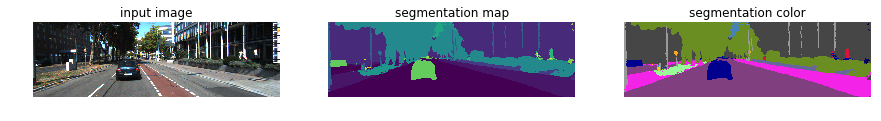

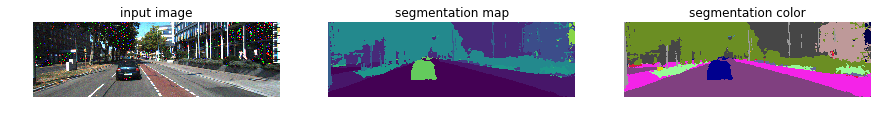

In [37]:
import os
import sys
import scipy
import numpy as np
import cv2
import tensorflow as tf
from matplotlib import gridspec
from matplotlib import pyplot as plt

def logits2image(logits):
    CITYSCAPE_PALLETE = np.asarray([
    [128, 64, 128],
    [244, 35, 232],
    [70, 70, 70],
    [102, 102, 156],
    [190, 153, 153],
    [153, 153, 153],
    [250, 170, 30],
    [220, 220, 0],
    [107, 142, 35],
    [152, 251, 152],
    [70, 130, 180],
    [220, 20, 60],
    [255, 0, 0],
    [0, 0, 142],
    [0, 0, 70],
    [0, 60, 100],
    [0, 80, 100],
    [0, 0, 230],
    [119, 11, 32],
    [0, 0, 0]], dtype=np.uint8)

    width = logits.shape[1] 
    height = logits.shape[0]
    logits = logits.astype(np.uint8)
    image = np.empty([height,width,3],dtype=float)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if(logits[i,j] == 255):
                image[i,j,:] = CITYSCAPE_PALLETE[19,:]
            else:
                image[i,j,:] = CITYSCAPE_PALLETE[logits[i,j],:]
    image = image.astype(np.uint8)
    return image

def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name="prefix")
    return graph

#graph = load_graph(sys.argv[1])
#image_dir = sys.argv[2]
#model_dir = '/data/tmpexec/deeplabv3_kitti/frozen_inference_graph.pb'
model_dir = '/data/tmpexec/deeplabv3_cityscapes_train/frozen_inference_graph.pb'
graph = load_graph(model_dir)
image_dir = '/data/tmpexec/deeplabimage'

# DeepLabv3+ input and output tensors
image_input = graph.get_tensor_by_name('prefix/ImageTensor:0')
softmax = graph.get_tensor_by_name('prefix/SemanticPredictions:0')

image_dir_segmented = image_dir+'/segmented_images'
image_dir_segmented_colored = image_dir+'/segmented_images_colored'

with tf.Session(graph=graph) as sess:
    for fname in sorted(os.listdir(image_dir)): #list all images
        if fname.endswith(".png"):
            img = scipy.misc.imread(os.path.join(image_dir, fname)) 
            Original_image = img
            img = np.expand_dims(img, axis=0)
            probs = sess.run(softmax, {image_input: img})
            img = tf.squeeze(probs).eval()
            Segmented_image = img
            img_colored = logits2image(img)
            segmented_colored_image = img_colored
            cv2.imwrite(os.path.join(image_dir_segmented+fname),img)
            cv2.imwrite(os.path.join(image_dir_segmented_colored+fname),cv2.cvtColor(img_colored, cv2.COLOR_BGR2RGB))   

            #show
            """Visualizes input image, segmentation map and overlay view."""
            plt.figure(figsize=(15, 5))
            grid_spec = gridspec.GridSpec(1, 3)

            plt.subplot(grid_spec[0])
            plt.imshow(Original_image)
            plt.axis('off')
            plt.title('input image')

            plt.subplot(grid_spec[1])
            plt.imshow(Segmented_image)
            plt.axis('off')
            plt.title('segmentation map')

            plt.subplot(grid_spec[2])
            plt.imshow(segmented_colored_image)
            plt.axis('off')
            plt.title('segmentation color')
            plt.show()